# Loading Data + Make Basic Observations

In [1]:
# Load the data
import pandas as pd
train_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/train.csv")
test_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/test.csv")

In [ ]:
# Get all of the unique labels for train / test sets 
train_labels = list(train_df['room'].unique())
test_labels = list(test_df['room'].unique())

# Labels that appear in BOTH train and test
zone_3 = ['507', '508', '510', '511', '512', '518', '520', '521', '522', '523']
common_labels = list(set(train_labels) & set(test_labels))
chosen_values = [room for room in zone_3 if room in common_labels]

# Now filter the train_df and test_df so that
# remove all record in train_df whose labels not in test labels 
# and remove all record in test_df whose labels not in train labels 
# therefore we can have a proper train and test df such that the labels appear 
# in train and test should be the same and vice versa
train_df = train_df[train_df['room'].isin(chosen_values)].reset_index(drop=True)
test_df  = test_df[test_df['room'].isin(chosen_values)].reset_index(drop=True)

In [3]:
# sanity check for label matching between train and test set
assert set(train_df['room'].unique()) == set(test_df['room'].unique())
print("Train/Test labels are now perfectly aligned")

Train/Test labels are now perfectly aligned


In [4]:
# check the distribution of classes in training set
train_df['room'].value_counts()

room
523    22169
511     8505
522     8079
512     3773
520     3695
518      252
Name: count, dtype: int64

# Create fixed 25 - beacons vector

In [5]:
# Function to add 25 beacon_1, beacon_2, ... , beacon_25
def add_beacon_features(df, num_beacons=25):
    df = df.copy()

    for i in range(1, num_beacons + 1):
        df[f'beacon_{i}'] = df['RSSI'].where(df['mac address'] == i, 0)

    return df

# Apply with our current train and test dataframe
train_df = add_beacon_features(train_df)
test_df = add_beacon_features(test_df)

In [6]:
train_df.head(1)

,timestamp,mac address,RSSI,room,beacon_1,beacon_2,beacon_3,beacon_4,beacon_5,beacon_6,...,beacon_16,beacon_17,beacon_18,beacon_19,beacon_20,beacon_21,beacon_22,beacon_23,beacon_24,beacon_25
0,2023-04-10 14:30:27+09:00,20,-84,520,0,0,0,0,0,0,...,0,0,0,0,-84,0,0,0,0,0


In [7]:
test_df.head(1)

,timestamp,mac address,RSSI,room,beacon_1,beacon_2,beacon_3,beacon_4,beacon_5,beacon_6,...,beacon_16,beacon_17,beacon_18,beacon_19,beacon_20,beacon_21,beacon_22,beacon_23,beacon_24,beacon_25
0,2023-04-12 10:11:06+09:00,8,-95,520,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature Engineering Function + Apply Windowing

In [8]:
# ============================================================================
# FIXED VERSION - Proper column naming for 'room'
# ============================================================================

# Cell 1: Define the aggregation function (FIXED)
def aggregate_by_timestamp(df):
    """
    Aggregate beacon data by timestamp (1-second windows)
    Since timestamp is already at second precision, this naturally creates 1-second windows
    """
    df = df.copy()
    
    # Build aggregation dictionary
    agg_dict = {}
    
    # For each of the 25 beacons: mean, std, max, min, count
    for i in range(1, 26):
        beacon_col = f'beacon_{i}'
        agg_dict[beacon_col] = ['mean', 'std', 'max', 'min', 'count']
    
    # For room: take first value (should be consistent within same timestamp)
    agg_dict['room'] = 'first'
    
    # Group by timestamp and aggregate
    windowed_df = df.groupby('timestamp').agg(agg_dict)
    
    # Flatten multi-level column names
    new_columns = []
    for col in windowed_df.columns.values:
        if col[0] == 'room':
            # Keep 'room' as is, don't add '_first'
            new_columns.append('room')
        elif col[1]:
            # For beacon columns, join with underscore
            new_columns.append('_'.join(col))
        else:
            new_columns.append(col[0])
    
    windowed_df.columns = new_columns
    
    # Reset index to make timestamp a regular column
    windowed_df = windowed_df.reset_index()
    
    # Fill NaN (happens when std calculated on single value) with 0
    windowed_df = windowed_df.fillna(0)
    
    # CRITICAL: Filter out windows where NO beacons were detected
    # This prevents the "room 0" issue
    beacon_mean_cols = [f'beacon_{i}_mean' for i in range(1, 26)]
    valid_windows = windowed_df[beacon_mean_cols].sum(axis=1) != 0
    
    removed_count = (~valid_windows).sum()
    windowed_df = windowed_df[valid_windows].reset_index(drop=True)
    
    print(f"Total windows after aggregation: {len(windowed_df)}")
    print(f"Removed {removed_count} empty windows (no beacon detections)")
    
    return windowed_df


# Apply aggregation to training data
print("Aggregating training data by timestamp...")
windowed_train_df = aggregate_by_timestamp(train_df)

print("\nTraining data shape after windowing:", windowed_train_df.shape)
print("\nRoom distribution:")
print(windowed_train_df['room'].value_counts())


# Apply aggregation to test data
print("\nAggregating test data by timestamp...")
windowed_test_df = aggregate_by_timestamp(test_df)

print("\nTest data shape after windowing:", windowed_test_df.shape)
print("\nRoom distribution:")
print(windowed_test_df['room'].value_counts())

Aggregating training data by timestamp...
Total windows after aggregation: 743
Removed 0 empty windows (no beacon detections)

Training data shape after windowing: (743, 127)

Room distribution:
room
523    232
522    181
512    159
511     96
520     70
518      5
Name: count, dtype: int64

Aggregating test data by timestamp...
Total windows after aggregation: 509
Removed 0 empty windows (no beacon detections)

Test data shape after windowing: (509, 127)

Room distribution:
room
520    190
512    133
523    110
511     46
522     17
518     13
Name: count, dtype: int64


In [9]:
windowed_train_df.head()

,timestamp,beacon_1_mean,beacon_1_std,beacon_1_max,beacon_1_min,beacon_1_count,beacon_2_mean,beacon_2_std,beacon_2_max,beacon_2_min,...,beacon_24_std,beacon_24_max,beacon_24_min,beacon_24_count,beacon_25_mean,beacon_25_std,beacon_25_max,beacon_25_min,beacon_25_count,room
0,2023-04-10 14:30:27+09:00,0.0,0.0,0,0,142,0.0,0.0,0,0,...,0.0,0,0,142,0.0,0.0,0,0,142,520
1,2023-04-10 14:30:28+09:00,0.0,0.0,0,0,173,0.0,0.0,0,0,...,0.0,0,0,173,0.0,0.0,0,0,173,520
2,2023-04-10 14:30:29+09:00,0.0,0.0,0,0,158,0.0,0.0,0,0,...,0.0,0,0,158,0.0,0.0,0,0,158,520
3,2023-04-10 14:30:30+09:00,0.0,0.0,0,0,154,0.0,0.0,0,0,...,0.0,0,0,154,0.0,0.0,0,0,154,520
4,2023-04-10 14:30:31+09:00,0.0,0.0,0,0,2,0.0,0.0,0,0,...,0.0,0,0,2,0.0,0.0,0,0,2,520


In [10]:
windowed_test_df.head()

,timestamp,beacon_1_mean,beacon_1_std,beacon_1_max,beacon_1_min,beacon_1_count,beacon_2_mean,beacon_2_std,beacon_2_max,beacon_2_min,...,beacon_24_std,beacon_24_max,beacon_24_min,beacon_24_count,beacon_25_mean,beacon_25_std,beacon_25_max,beacon_25_min,beacon_25_count,room
0,2023-04-12 10:11:06+09:00,0.0,0.0,0,0,5,0.0,0.0,0,0,...,0.0,0,0,5,0.0,0.0,0,0,5,520
1,2023-04-12 10:11:07+09:00,0.0,0.0,0,0,5,0.0,0.0,0,0,...,0.0,0,0,5,0.0,0.0,0,0,5,520
2,2023-04-12 10:11:14+09:00,0.0,0.0,0,0,15,0.0,0.0,0,0,...,0.0,0,0,15,0.0,0.0,0,0,15,520
3,2023-04-12 10:11:17+09:00,0.0,0.0,0,0,5,0.0,0.0,0,0,...,0.0,0,0,5,0.0,0.0,0,0,5,520
4,2023-04-12 10:11:20+09:00,0.0,0.0,0,0,5,0.0,0.0,0,0,...,0.0,0,0,5,0.0,0.0,0,0,5,520


### Train XGBoost Models

In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Prepare training data
print("=" * 80)
print("TRAINING XGBOOST MODEL")
print("=" * 80)

# Separate features and labels
feature_cols = [col for col in windowed_train_df.columns 
                if col not in ['room', 'timestamp']]

X_train = windowed_train_df[feature_cols]
y_train = windowed_train_df['room']

print(f"Training samples: {len(X_train)}")
print(f"Number of features: {len(feature_cols)}")
print(f"Number of classes: {len(y_train.unique())}")
print(f"Class distribution:\n{y_train.value_counts()}\n")

# Encode labels for XGBoost (XGBoost requires numeric labels)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Calculate class weights for balanced training (macro F1 optimization)
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Train XGBoost with parameters optimized for macro F1
xgb_model = xgb.XGBClassifier(
    n_estimators=100,           # Number of boosting rounds
    max_depth=6,                # Maximum tree depth (usually shallower than RF)
    learning_rate=0.1,          # Step size shrinkage
    min_child_weight=1,         # Minimum sum of instance weight in a child
    subsample=0.8,              # Subsample ratio of training instances
    colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
    gamma=0,                    # Minimum loss reduction for split
    reg_alpha=0,                # L1 regularization
    reg_lambda=1,               # L2 regularization
    objective='multi:softmax',  # Multiclass classification
    num_class=len(y_train.unique()),
    eval_metric='mlogloss',     # Evaluation metric
    random_state=42,
    n_jobs=-1,
    tree_method='hist'          # Faster histogram-based algorithm
)

print("Training XGBoost...")
xgb_model.fit(
    X_train, 
    y_train_encoded,
    sample_weight=sample_weights  # Apply class balancing through sample weights
)
print("Training completed!")

# Training accuracy
train_pred_encoded = xgb_model.predict(X_train)
train_pred = label_encoder.inverse_transform(train_pred_encoded)
train_f1 = f1_score(y_train, train_pred, average='macro')
print(f"\nTraining Macro F1-Score: {train_f1:.4f}")

TRAINING XGBOOST MODEL
Training samples: 743
Number of features: 125
Number of classes: 6
Class distribution:
room
523    232
522    181
512    159
511     96
520     70
518      5
Name: count, dtype: int64

Training XGBoost...
Training completed!

Training Macro F1-Score: 0.9827


### Evaluate on Windowed Test Data

In [12]:
# Prepare test data
print("=" * 80)
print("EVALUATION ON WINDOWED TEST DATA")
print("=" * 80)

X_test = windowed_test_df[feature_cols]
y_test = windowed_test_df['room']

print(f"Test samples: {len(X_test)}")
print(f"Test class distribution:\n{y_test.value_counts()}\n")

# Predict on windowed test data
y_pred_encoded = xgb_model.predict(X_test)

# ⭐ CRITICAL: Inverse transform predictions back to original labels
y_pred_windowed = label_encoder.inverse_transform(y_pred_encoded)

# Calculate macro F1 on windowed data
windowed_macro_f1 = f1_score(y_test, y_pred_windowed, average='macro')
print(f"Windowed Test Macro F1-Score: {windowed_macro_f1:.4f}\n")

# Per-class metrics
print("=" * 80)
print("PER-CLASS METRICS (WINDOWED)")
print("=" * 80)
print(classification_report(y_test, y_pred_windowed, zero_division=0))

# Store predictions in windowed_test_df for propagation
windowed_test_df['predicted_room'] = y_pred_windowed

EVALUATION ON WINDOWED TEST DATA
Test samples: 509
Test class distribution:
room
520    190
512    133
523    110
511     46
522     17
518     13
Name: count, dtype: int64

Windowed Test Macro F1-Score: 0.4400

PER-CLASS METRICS (WINDOWED)
              precision    recall  f1-score   support

         511       0.44      0.52      0.48        46
         512       0.66      0.40      0.50       133
         518       0.00      0.00      0.00        13
         520       0.85      0.75      0.80       190
         522       0.17      0.65      0.27        17
         523       0.55      0.65      0.60       110

    accuracy                           0.60       509
   macro avg       0.45      0.50      0.44       509
weighted avg       0.66      0.60      0.61       509



### Propagate Predictions to Frame-Level

In [13]:
# ============================================================================
# SIMPLE FIX: Propagate Window Predictions to Frame Level
# ============================================================================

print("=" * 80)
print("PROPAGATING PREDICTIONS TO FRAME LEVEL")
print("=" * 80)

# Step 1: Prepare test_df - convert timestamp and floor to 1-second
test_df_eval = test_df.copy()
test_df_eval['timestamp'] = pd.to_datetime(test_df_eval['timestamp'])
test_df_eval['timestamp_1s'] = test_df_eval['timestamp'].dt.floor('1S')

# Step 2: Prepare windowed predictions - also convert timestamp
window_predictions = windowed_test_df[['timestamp', 'predicted_room']].copy()
window_predictions['timestamp'] = pd.to_datetime(window_predictions['timestamp'])
window_predictions['timestamp_1s'] = window_predictions['timestamp'].dt.floor('1S')

# Drop the original timestamp column, keep only timestamp_1s
window_predictions = window_predictions[['timestamp_1s', 'predicted_room']]

# Step 3: Merge - each frame gets prediction from its window
test_df_eval = test_df_eval.merge(window_predictions, on='timestamp_1s', how='left')

print(f"Original test frames: {len(test_df_eval)}")
print(f"Frames with predictions: {test_df_eval['predicted_room'].notna().sum()}")

# Step 4: Handle missing predictions (safety check)
if test_df_eval['predicted_room'].isna().any():
    missing_count = test_df_eval['predicted_room'].isna().sum()
    print(f"WARNING: {missing_count} frames missing predictions")
    test_df_eval['predicted_room'] = test_df_eval['predicted_room'].fillna(
        test_df_eval['predicted_room'].mode()[0]
    )

print("\nPropagation completed!")

# Step 5: Evaluate on frame-level
print("\n" + "=" * 80)
print("EVALUATION ON FRAME-LEVEL TEST DATA")
print("=" * 80)

y_true_frames = test_df_eval['room']
y_pred_frames = test_df_eval['predicted_room']

frame_macro_f1 = f1_score(y_true_frames, y_pred_frames, average='macro')
print(f"\nFrame-Level Test Macro F1-Score: {frame_macro_f1:.4f}")

print("\n" + "=" * 80)
print("PER-CLASS METRICS (FRAME-LEVEL)")
print("=" * 80)
print(classification_report(y_true_frames, y_pred_frames, zero_division=0))

PROPAGATING PREDICTIONS TO FRAME LEVEL
Original test frames: 23383
Frames with predictions: 23383

Propagation completed!

EVALUATION ON FRAME-LEVEL TEST DATA

Frame-Level Test Macro F1-Score: 0.4212

PER-CLASS METRICS (FRAME-LEVEL)
              precision    recall  f1-score   support

         511       0.48      0.51      0.50      2042
         512       0.64      0.25      0.36      5635
         518       0.00      0.00      0.00       180
         520       0.76      0.67      0.71      6125
         522       0.14      0.56      0.22       917
         523       0.70      0.78      0.74      8484

    accuracy                           0.59     23383
   macro avg       0.45      0.46      0.42     23383
weighted avg       0.65      0.59      0.59     23383



In [14]:
# ============================================================================
# CONFUSION MATRICES - Window Level and Frame Level
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

CONFUSION MATRIX - WINDOW LEVEL


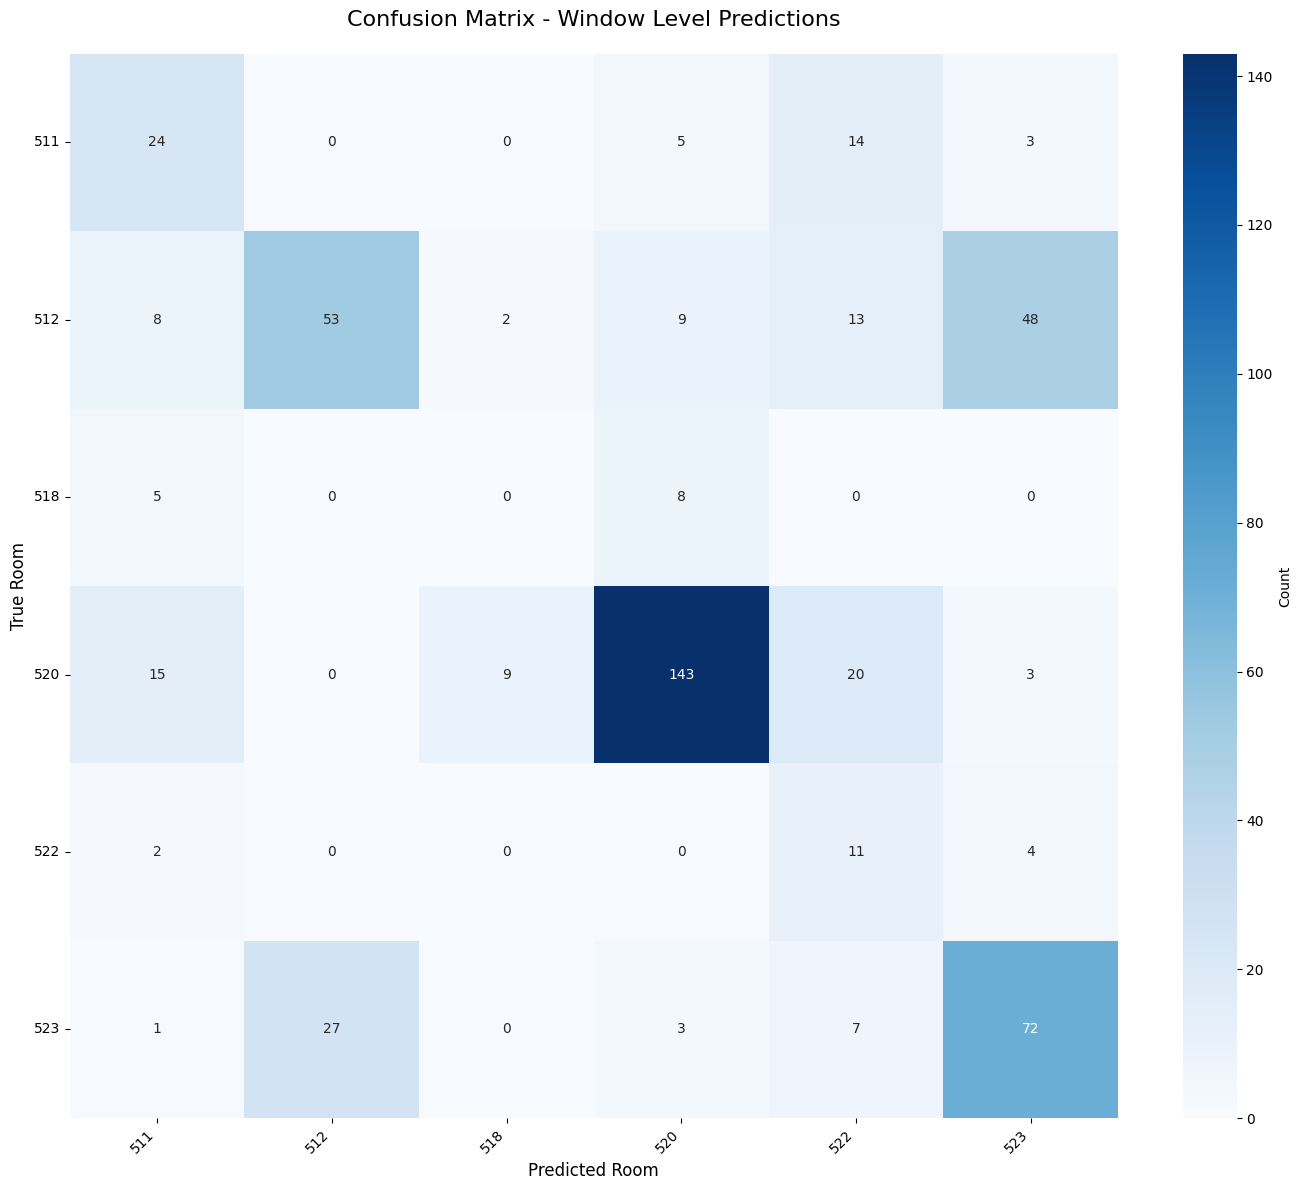


Total predictions: 509
Correct predictions: 303
Accuracy: 0.5953


In [15]:
# Confusion Matrix for WINDOW-LEVEL Predictions
print("=" * 80)
print("CONFUSION MATRIX - WINDOW LEVEL")
print("=" * 80)

# Get the 16 classes (sorted for consistent ordering)
classes = sorted(train_df['room'].unique())

# Compute confusion matrix
cm_window = confusion_matrix(y_test, y_pred_windowed, labels=classes)

# Create figure
plt.figure(figsize=(14, 12))
sns.heatmap(cm_window, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Window Level Predictions', fontsize=16, pad=20)
plt.xlabel('Predicted Room', fontsize=12)
plt.ylabel('True Room', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTotal predictions: {cm_window.sum()}")
print(f"Correct predictions: {np.trace(cm_window)}")
print(f"Accuracy: {np.trace(cm_window) / cm_window.sum():.4f}")


CONFUSION MATRIX - FRAME LEVEL


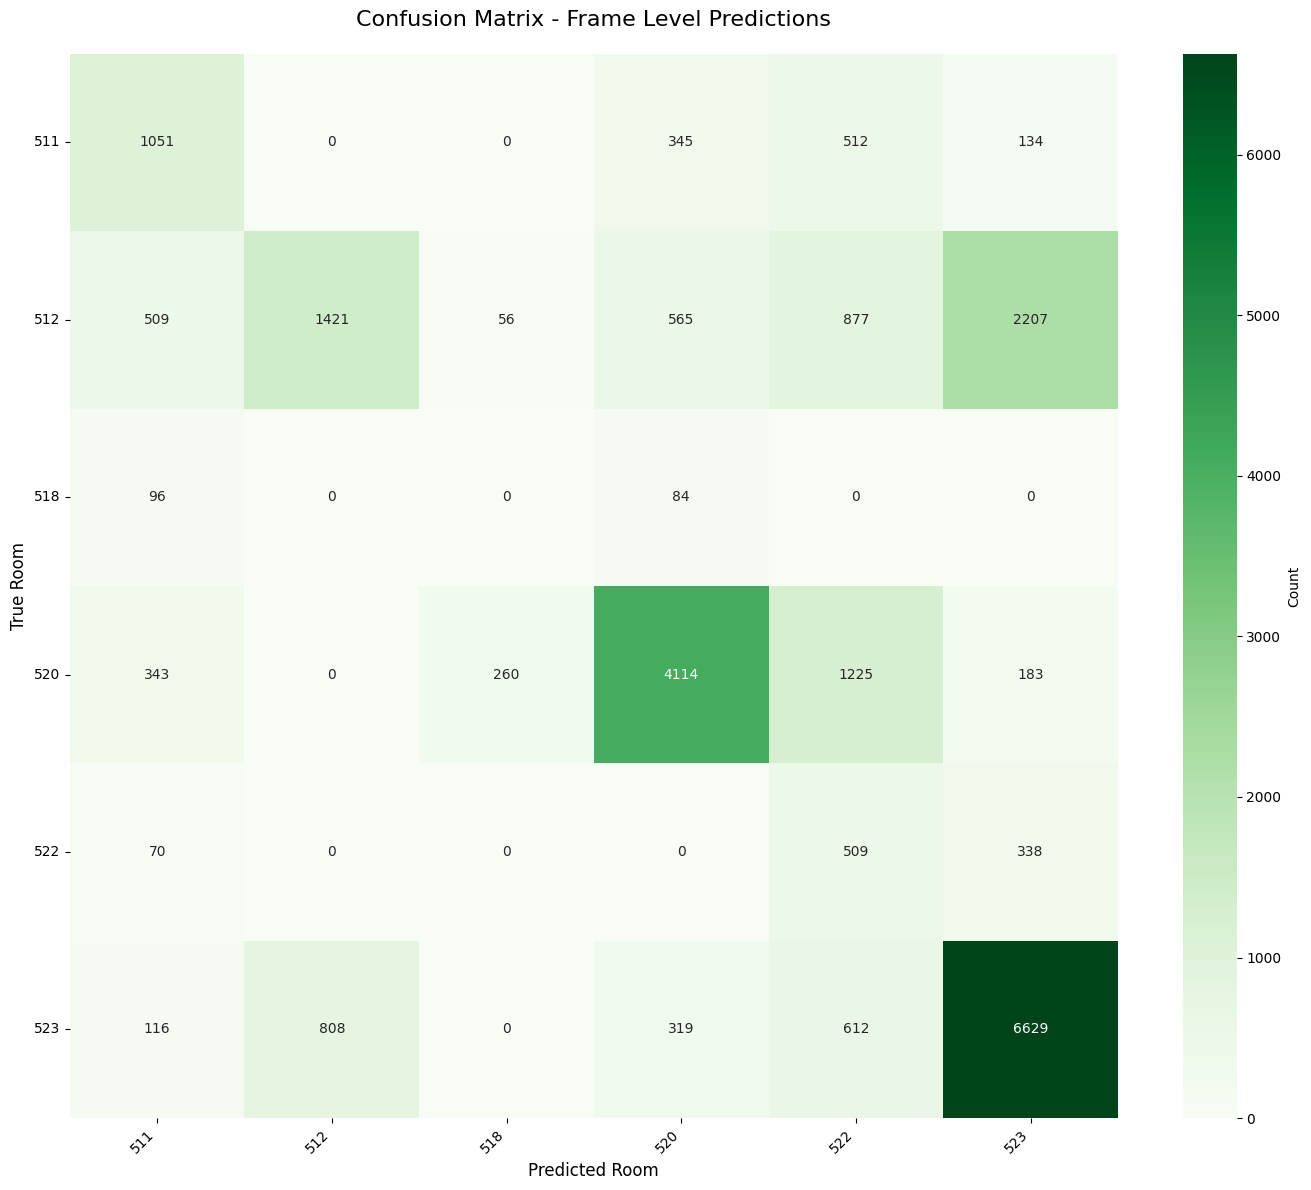


Total predictions: 23383
Correct predictions: 13724
Accuracy: 0.5869

SIDE-BY-SIDE COMPARISON


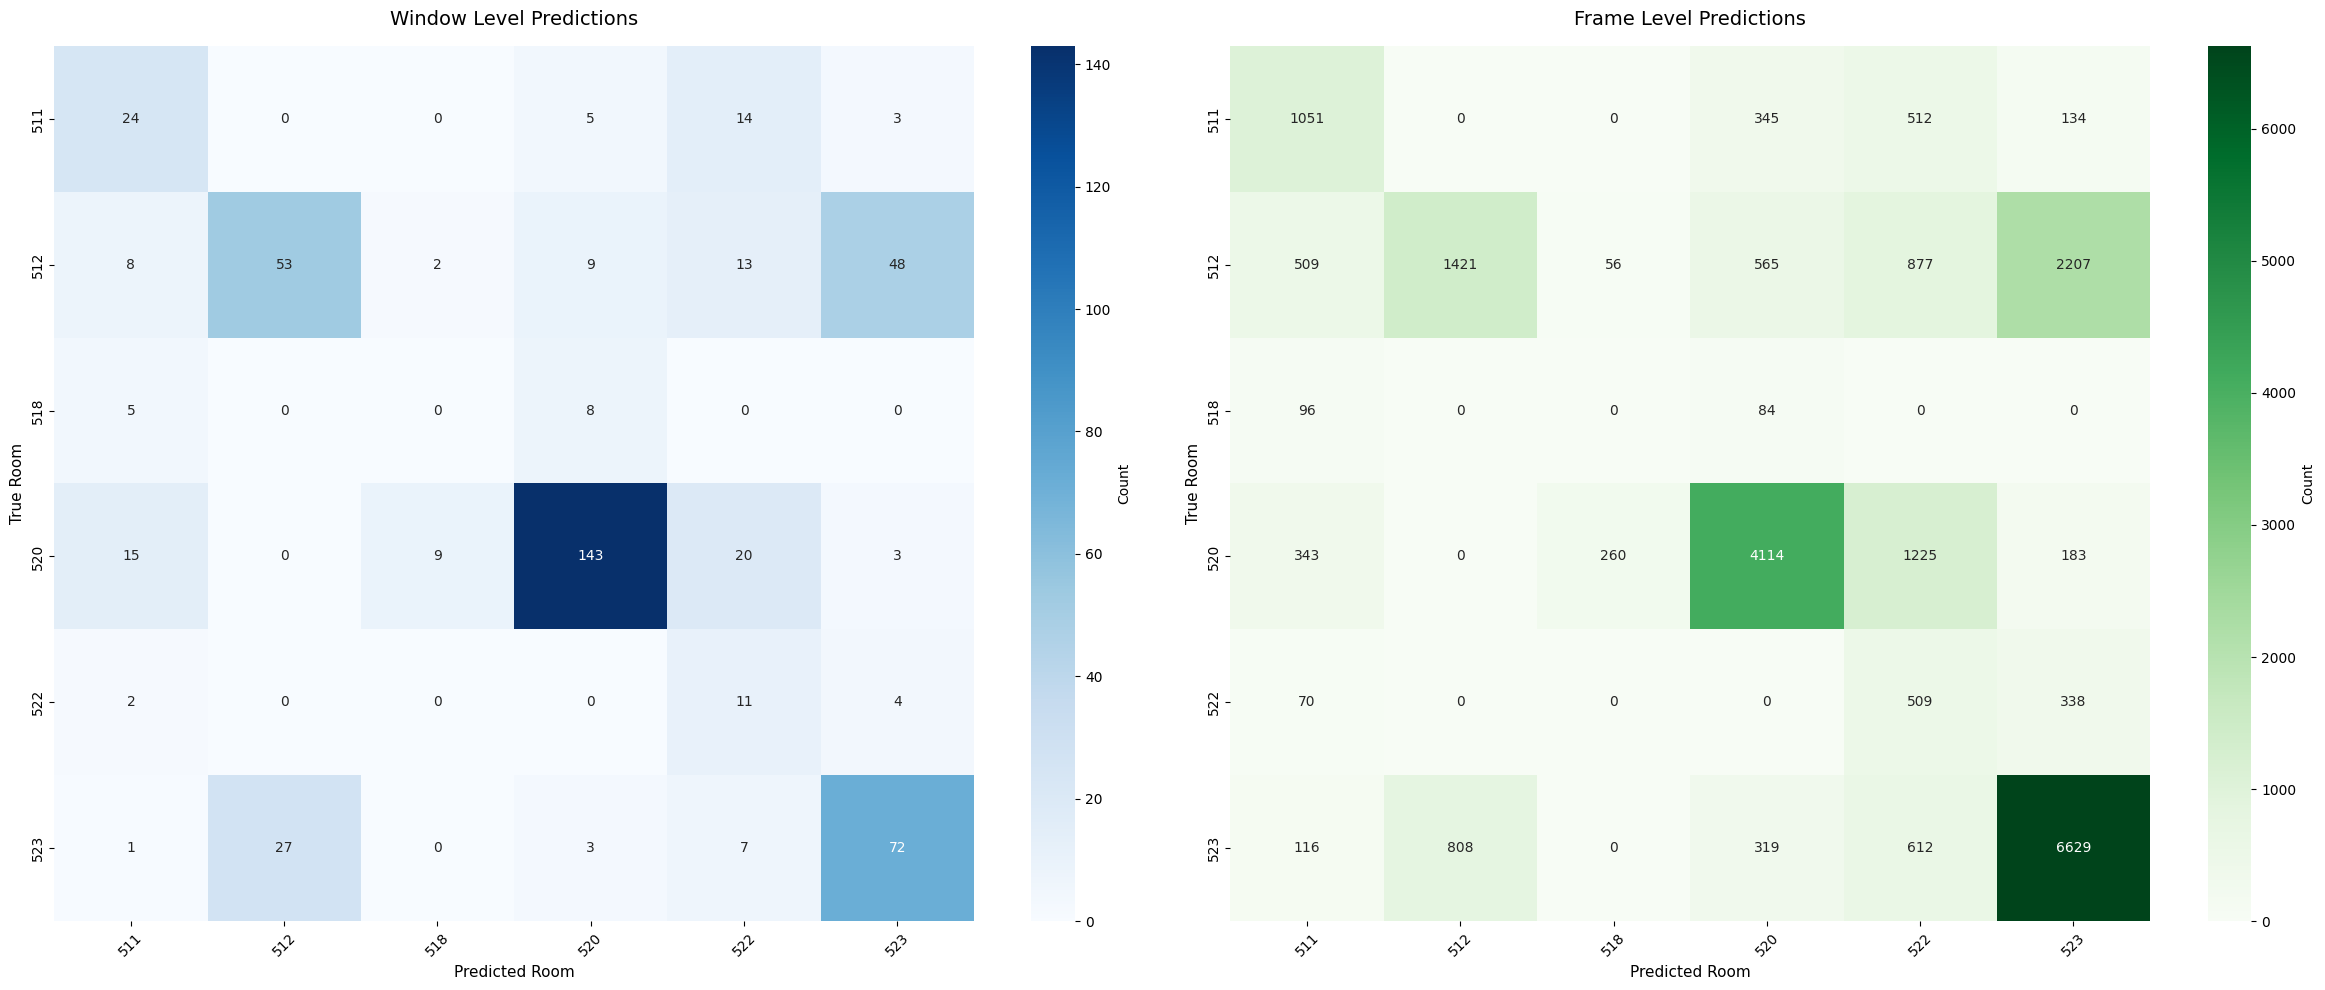


ACCURACY COMPARISON
Window-Level Accuracy: 0.5953
Frame-Level Accuracy:  0.5869
Difference:            -0.0084


In [16]:
# Confusion Matrix for FRAME-LEVEL Predictions
print("\n" + "=" * 80)
print("CONFUSION MATRIX - FRAME LEVEL")
print("=" * 80)

# Compute confusion matrix
cm_frame = confusion_matrix(y_true_frames, y_pred_frames, labels=classes)

# Create figure
plt.figure(figsize=(14, 12))
sns.heatmap(cm_frame, 
            annot=True, 
            fmt='d', 
            cmap='Greens',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Frame Level Predictions', fontsize=16, pad=20)
plt.xlabel('Predicted Room', fontsize=12)
plt.ylabel('True Room', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTotal predictions: {cm_frame.sum()}")
print(f"Correct predictions: {np.trace(cm_frame)}")
print(f"Accuracy: {np.trace(cm_frame) / cm_frame.sum():.4f}")


# Cell 3: Side-by-Side Comparison (OPTIONAL - if you want both in one view)
print("\n" + "=" * 80)
print("SIDE-BY-SIDE COMPARISON")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Window-level
sns.heatmap(cm_window, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Count'},
            ax=axes[0])
axes[0].set_title('Window Level Predictions', fontsize=14, pad=15)
axes[0].set_xlabel('Predicted Room', fontsize=11)
axes[0].set_ylabel('True Room', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)

# Frame-level
sns.heatmap(cm_frame, 
            annot=True, 
            fmt='d', 
            cmap='Greens',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Count'},
            ax=axes[1])
axes[1].set_title('Frame Level Predictions', fontsize=14, pad=15)
axes[1].set_xlabel('Predicted Room', fontsize=11)
axes[1].set_ylabel('True Room', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Comparison summary
print("\n" + "=" * 80)
print("ACCURACY COMPARISON")
print("=" * 80)
window_acc = np.trace(cm_window) / cm_window.sum()
frame_acc = np.trace(cm_frame) / cm_frame.sum()

print(f"Window-Level Accuracy: {window_acc:.4f}")
print(f"Frame-Level Accuracy:  {frame_acc:.4f}")
print(f"Difference:            {frame_acc - window_acc:.4f}")
